# GAN

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


## The Data

In [2]:
def one_hot(x):
    a = [0]*10
    a[x]=1
    return a

In [3]:
with np.load('mnist.npz') as data:
    train_examples = data['x_train'].reshape(-1,784)
    train_labels = list(map(one_hot,data['y_train']))
    test_examples = data['x_test'].reshape(-1,784)
    test_labels = list(map(one_hot,data['y_test']))
print(train_examples.shape)

(60000, 784)


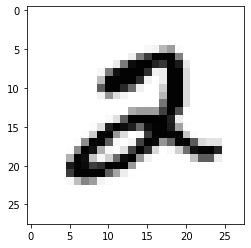

In [4]:
plt.imshow(train_examples[5].reshape(28,28),cmap='Greys')

# The Networks


### Activation Function

In [5]:
act_func = tf.nn.leaky_relu

In [6]:
initializer = tf.variance_scaling_initializer()

## The Generator

In [7]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        wg1 = tf.Variable(initializer([100, 128]), dtype=tf.float32)
        bg1 = tf.Variable(tf.zeros(128))
#         hidden1 = act_func(tf.matmul(z, wg1) + bg1)
        hidden1 = tf.matmul(z, wg1) + bg1
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        wg2 = tf.Variable(initializer([128, 128]), dtype=tf.float32)
        bg2 = tf.Variable(tf.zeros(128))
#         hidden2 = act_func(tf.matmul(hidden1, wg2) + bg2)
        hidden2 = tf.matmul(hidden1, wg2) + bg2
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        wg3 = tf.Variable(initializer([128, 784]), dtype=tf.float32)
        bg3 = tf.Variable(tf.zeros(784))
#         output = tf.nn.tanh(tf.matmul(hidden2, wg3) + bg3)
        output = tf.matmul(hidden2, wg3) + bg3
#         output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
    

## The Discriminator

In [8]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        wd1 = tf.Variable(initializer([784, 128]), dtype=tf.float32)
        bd1 = tf.Variable(tf.zeros(128))
#         hidden1 = act_func(tf.matmul(X, wd1) + bd1)
        hidden1 = tf.matmul(X, wd1) + bd1
        
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        wd2 = tf.Variable(initializer([128, 128]), dtype=tf.float32)
        bd2 = tf.Variable(tf.zeros(128))
#         hidden2 = act_func(tf.matmul(hidden1, wd2) + bd2)
        hidden2 = tf.matmul(hidden1, wd2) + bd2
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        wd3 = tf.Variable(initializer([128, 1]), dtype=tf.float32)
        bd3 = tf.Variable(tf.zeros(1))
        logits = tf.matmul(hidden2, wd3) + bd3
        output = tf.sigmoid(logits)
        
        
        return output, logits

### Placeholders

In [9]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [10]:
G = generator(z)

### Discriminator 

In [11]:
D_output_real , D_logits_real = discriminator(real_images)

In [12]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

### Losses

In [13]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [14]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))

In [15]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_fake))

In [16]:
D_loss = D_real_loss + D_fake_loss

In [17]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimizers

In [18]:
learning_rate = 0.001

In [19]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/Variable:0', 'dis/Variable_1:0', 'dis/Variable_2:0', 'dis/Variable_3:0', 'dis/Variable_4:0', 'dis/Variable_5:0', 'dis_1/Variable:0', 'dis_1/Variable_1:0', 'dis_1/Variable_2:0', 'dis_1/Variable_3:0', 'dis_1/Variable_4:0', 'dis_1/Variable_5:0']
['gen/Variable:0', 'gen/Variable_1:0', 'gen/Variable_2:0', 'gen/Variable_3:0', 'gen/Variable_4:0', 'gen/Variable_5:0']


In [20]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Training Session

In [21]:
batch_size = 100
epochs = 20
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [22]:
# Save a sample per epoch
samples = []

In [23]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = train_examples.shape[0]//batch_size
        
        for i in range(num_batches):
            
            batch_images = train_examples[i*batch_size:(i+1)*batch_size]
            batch_images = batch_images*2 - 1
            
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
        d_l = sess.run(D_loss, feed_dict={real_images: batch_images, z: batch_z})
        g_l = sess.run(G_loss, feed_dict={z: batch_z})
        
        print("Currently on Epoch {} of {} total...\nd_l : {} g_l: {}".format(e+1, epochs,d_l, g_l))
 
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1,100))
        gen_sample = sess.run(G,
                              feed_dict={z: sample_z})
        
        samples.append(gen_sample)


Currently on Epoch 1 of 20 total...
d_l : 0.3779376447200775 g_l: 7.777933120727539
Currently on Epoch 2 of 20 total...
d_l : 1.0597972869873047 g_l: 9.45663833618164
Currently on Epoch 3 of 20 total...
d_l : 0.33696475625038147 g_l: 10.005206108093262
Currently on Epoch 4 of 20 total...
d_l : 0.3274150788784027 g_l: 11.850384712219238
Currently on Epoch 5 of 20 total...
d_l : 0.32653576135635376 g_l: 11.68542766571045
Currently on Epoch 6 of 20 total...
d_l : 0.32667359709739685 g_l: 11.831984519958496
Currently on Epoch 7 of 20 total...
d_l : 0.3260534107685089 g_l: 12.116098403930664
Currently on Epoch 8 of 20 total...
d_l : 0.3257454037666321 g_l: 12.43101692199707
Currently on Epoch 9 of 20 total...
d_l : 0.32565146684646606 g_l: 12.653266906738281
Currently on Epoch 10 of 20 total...
d_l : 0.3253895044326782 g_l: 12.529288291931152
Currently on Epoch 11 of 20 total...
d_l : 0.32531723380088806 g_l: 14.298015594482422
Currently on Epoch 12 of 20 total...
d_l : 0.325259268283844 g_

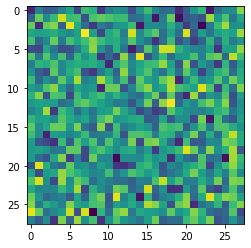

In [28]:
plt.imshow(samples[0].reshape(28,28))